# 4. Example: 4DVar Backprop DA using Reservoir Computing ML Model

In [1]:
import dabench as dab
import numpy as np
import matplotlib.pyplot as plt
from jax.scipy.sparse.linalg import bicgstab
from scipy.linalg import inv
from scipy.sparse.linalg import aslinearoperator
from copy import deepcopy
import jax.numpy as jnp
from jax import value_and_grad
from IPython.lib.deepreload import reload
import pickle

In [2]:
np_rng = np.random.default_rng(seed=50)

## A. Create Nature Run

In [3]:
train_size = 100000 
transient_size = 1000
test_size = 2000

In [4]:
# First define data generator and generate data
nature_run = dab.data.Lorenz96(system_dim=6, delta_t=0.01, store_as_jax=True)

In [5]:
nature_run.generate(n_steps=(train_size + transient_size + test_size))

In [6]:
nr_train, nr_transient, nr_test = nature_run.split_train_valid_test(train_size, transient_size, test_size)

## B. Generate Observations

In [43]:
# Now we can define the observer:
obs_l96 = dab.observer.Observer(
    nr_test, # Data generator object
    time_indices = np.arange(0, 2000, 5), # Observation every 5th timestep
    random_location_count = 3,
    error_bias = 0.0, 
    error_sd = 1.0, 
    random_seed=94,
    stationary_observers=True,
    store_as_jax=False
)

# Making observations
obs_vec_l96 = obs_l96.observe()

## C. Define and train model

In [8]:
# Define model
forecast_model = dab.model.RCModel(
    system_dim=6, 
    reservoir_dim=1600, 
    input_dim=6, 
    sparse_adj_matrix=False, 
    sparsity=0.99,
    readout_method='linear',
    sigma=0.07,
    spectral_radius = 0.1, 
    leak_rate=0.7,
    log_beta=-18.41)

In [9]:
# # Train: Takes ~5 minutes
# forecast_model.weights_init()
# forecast_model.train(nr_train)
# forecast_model.save_weights('./l96_rc_weights.pkl')

In [10]:
# Shortcut: load the W_out weights from previous training
weights_path = './l96_rc_weights.pkl'
forecast_model.weights_init()
forecast_model.load_weights(weights_path)

## D. Set up and run DA Cycler

In [44]:
sigma_obs=0.1
sigma_bg = 0.05
num_obs = 3

S = np.zeros((num_obs, nature_run.system_dim))
S[np.arange(S.shape[0]), np.tile(obs_vec_l96.location_indices[0], 1)] = 1
H = S @ forecast_model.Wout.T
R = sigma_obs*np.identity(num_obs)
B = sigma_bg*np.identity(forecast_model.reservoir_dim)


In [45]:
r0_original = forecast_model.update(forecast_model.generate(
        nr_transient.values
        + np.random.normal(size = (nr_transient.time_dim, nr_transient.system_dim), scale=0.05))[-1], nr_transient.values[-1])

In [46]:
num_iters_per_cycle=3

In [59]:
dc = dab.dacycler.Var4DBackprop(
    system_dim=forecast_model.reservoir_dim,
    delta_t=nature_run.delta_t,
    H=H,
    B=B,
    R=R,
    learning_rate=5e-6,
    num_iters=num_iters_per_cycle,
    model_obj=forecast_model,
    obs_window_indices=[0,5,10],
    steps_per_window=11, # 11 instead of 10 because inclusive of 0 and 11
    )


Run the cycler

In [60]:
cur_tstep = 0

r0_sv = dab.vector.StateVector(
    values=r0_original,
    store_as_jax=True)

out_statevec = dc.cycle(
    input_state = r0_sv,
    start_time = nr_test.times[cur_tstep],
    obs_vector = obs_vec_l96,
    analysis_window=0.1,
    timesteps=198,
    obs_error_sd=sigma_obs,
    analysis_time_in_window=0.05)

[[  59.74070399   58.29850889   57.60675954]
 [  69.62494016   63.41947281   60.26601128]
 [  43.78526138   43.27070023   42.82937726]
 [  77.68865067   73.2716998    69.96545113]
 [  49.94089328   43.06541199   39.0731455 ]
 [  31.3802372    25.98675141   23.54672341]
 [  46.59947688   37.70916145   33.90474474]
 [ 201.15512264  179.19435584  167.25205481]
 [ 178.46171059  178.07041422  177.69713816]
 [ 148.6242262   110.31364388   91.63888019]
 [  75.38777138   70.98392636   68.23247857]
 [  89.01355154   85.28691683   83.11190593]
 [  38.60210195   37.2945558    36.45203197]
 [  33.16741722   32.59996904   32.14371254]
 [  38.05458221   37.46569281   36.93197159]
 [  80.31836993   79.393833     78.54196831]
 [  53.89997044   50.09408699   47.3278028 ]
 [ 245.84390066  149.22139267   96.50300861]
 [  31.55451631   31.44006514   31.34414649]
 [  96.12369345   94.43788713   93.46518895]
 [  64.92183865   61.75456484   59.99268874]
 [  54.7458928    48.05647163   44.60249919]
 [  60.952

In [61]:
analyses_stacked = forecast_model.readout(out_statevec.values)

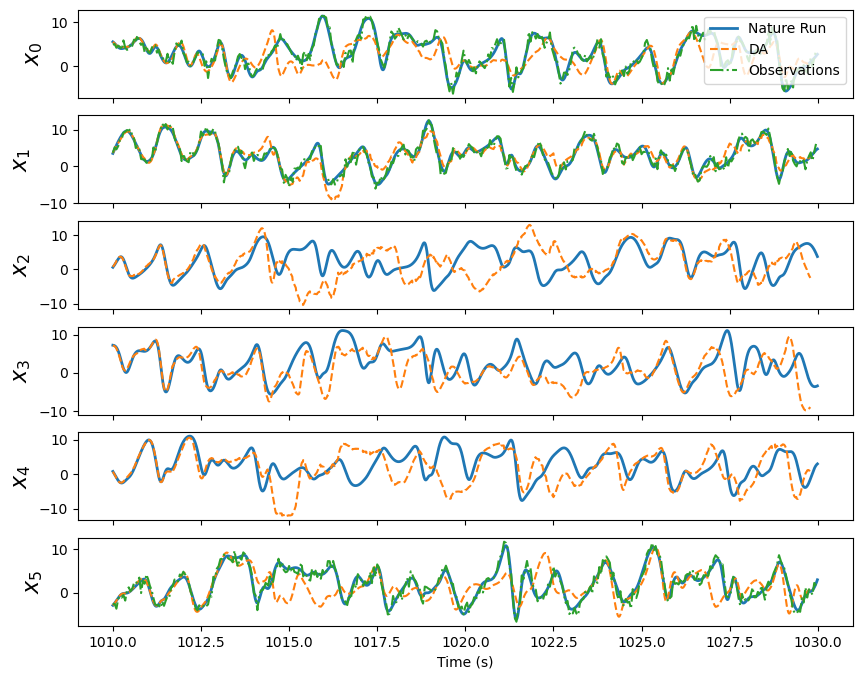

In [62]:
# Plot them all
i = 0
fig, axes = plt.subplots(6, 1, sharex = True, figsize = (10, 8))
for j, ax in enumerate(axes):
    ax.plot(nr_test.times, nr_test.values[:, j], label='Nature Run', lw=2)
    ax.plot(nr_test.times[:analyses_stacked.shape[0]], analyses_stacked[:, j],
        label='DA', ls='--', lw=1.5)
    if j in obs_vec_l96.location_indices[0]:
        ax.plot(obs_vec_l96.times, obs_vec_l96.values[:, i], label='Observations', lw=1.5, ls='-.')
        i += 1
    ax.set_ylabel(r'$x_{:d}$'.format(j), fontsize = 16)
    if j ==0:
        ax.legend()
ax.set_xlabel('Time (s)')        
plt.show()